In [ ]:
# Module X0: Setup & Reproducibility
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("Seed set:", SEED)

Seed set: 42


In [ ]:
# Module X1: Install & Imports
!pip -q install xgboost

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

print("XGBoost version:", xgb.__version__)

XGBoost version: 3.0.3


In [ ]:
# Module X2: Load dataset
from google.colab import drive
drive.mount('/content/drive')

# Set your path
# NPZ_PATH = "/content/drive/MyDrive/Summer 2025/APS 360/ML_processed_data.npz"  # <- round 1 data
NPZ_PATH = "/content/drive/MyDrive/Summer 2025/APS 360/Group 31 Project/ML_processed_data_APS360_FFTMAG_newCSV.npz"  # <- round 2 data

data = np.load(NPZ_PATH)
X = data["X"]   # shape: (N, F)
y = data["y"]   # shape: (N,)
print("Raw X shape:", X.shape, " y shape:", y.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw X shape: (204953, 197)  y shape: (204953, 1)


In [ ]:
# Module X3: Split Data
# 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=SEED
)

# 20% val, 20% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

y_train = np.asarray(y_train, dtype="float32").ravel()
y_val   = np.asarray(y_val,   dtype="float32").ravel()
y_test  = np.asarray(y_test,  dtype="float32").ravel()


Train: (122971, 197)  Val: (40991, 197)  Test: (40991, 197)


[0]	train-rmse:1800.30495	val-rmse:1799.27336
[1]	train-rmse:1722.29207	val-rmse:1721.58746
[2]	train-rmse:1651.35238	val-rmse:1650.94116
[3]	train-rmse:1579.11044	val-rmse:1579.19799
[4]	train-rmse:1514.64202	val-rmse:1515.26463
[5]	train-rmse:1454.37584	val-rmse:1455.03009
[6]	train-rmse:1392.74895	val-rmse:1393.87987
[7]	train-rmse:1335.52912	val-rmse:1336.99232
[8]	train-rmse:1284.80168	val-rmse:1286.84548
[9]	train-rmse:1233.71482	val-rmse:1236.12687
[10]	train-rmse:1184.18259	val-rmse:1187.08366
[11]	train-rmse:1136.89706	val-rmse:1140.48161
[12]	train-rmse:1096.06167	val-rmse:1100.36345
[13]	train-rmse:1053.41039	val-rmse:1058.42733
[14]	train-rmse:1013.74105	val-rmse:1019.28247
[15]	train-rmse:976.47687	val-rmse:982.61053
[16]	train-rmse:940.89268	val-rmse:947.69055
[17]	train-rmse:908.38812	val-rmse:915.76087
[18]	train-rmse:877.03922	val-rmse:884.97106
[19]	train-rmse:849.57758	val-rmse:857.83348
[20]	train-rmse:821.68950	val-rmse:830.84220
[21]	train-rmse:796.47164	val-rmse:

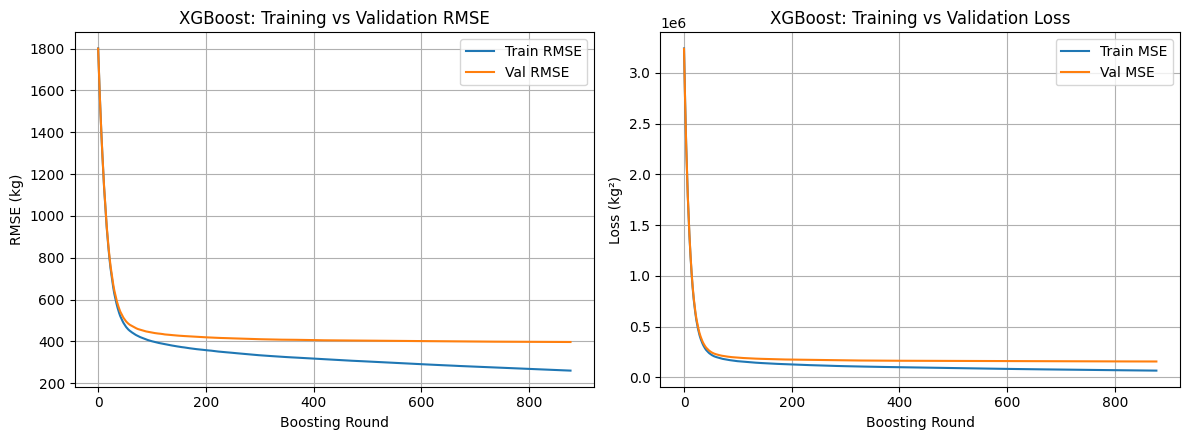

TEST — RMSE: 398.13 kg | R²: 0.956 | slope: 0.946 | intercept: 269.35
TEST within 10 kg:     3.27%
TEST within 100 kg:   29.75%
TEST within 1000 kg:  98.35%


In [ ]:
# === Module X5: XGBoost baseline (with TEST support) ===
# Expected inputs: X_train_s, y_train, X_val_s, y_val, X_test_s, y_test
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) DMatrices
dtrain = xgb.DMatrix(X_train_s, label=y_train)
dval   = xgb.DMatrix(X_val_s,   label=y_val)
dtest  = xgb.DMatrix(X_test_s,  label=y_test)

params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "device": "cuda",          # set to "cpu" if needed
    "eval_metric": "rmse",
    "seed": 42,
    "learning_rate": 0.05,
    "max_depth": 7,
    "min_child_weight": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.0,
    "reg_lambda": 5.0,
    "gamma": 0.1,
}

# 2) Train with early stopping (monitored on validation)
num_boost_round = 1000
early_stopping_rounds = 5
watchlist = [(dtrain, "train"), (dval, "val")]
evals_result = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_result,
    verbose_eval=True
)

best_iter = bst.best_iteration
print("Best iteration:", best_iter)

# 3) Helper: evaluate & plot one split
def eval_and_plot(dmat, y_true_raw, split_name="Validation"):
    y_pred = bst.predict(dmat, iteration_range=(0, best_iter + 1))
    y_true = np.asarray(y_true_raw).ravel()
    y_pred = np.asarray(y_pred).ravel()

    # Guard/align
    assert y_true.shape[0] == y_pred.shape[0], (
        f"Length mismatch: y_true={y_true.shape[0]}, y_pred={y_pred.shape[0]}"
    )
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true, y_pred = y_true[mask], y_pred[mask]

    # Metrics
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    m, b = np.polyfit(y_true, y_pred, 1)
    print(f"{split_name} — RMSE: {rmse:.2f} kg | R²: {r2:.3f} | slope: {m:.3f} | intercept: {b:.2f}")

    # Curves pulled from eval history (train/val only)
    if split_name == "Validation":
      train_rmse = evals_result["train"]["rmse"]
      val_rmse   = evals_result["val"]["rmse"]
      train_loss = np.square(train_rmse)
      val_loss   = np.square(val_rmse)

      # Side-by-side plots
      fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

      # RMSE curve
      axes[0].plot(train_rmse, label="Train RMSE")
      axes[0].plot(val_rmse,   label="Val RMSE")
      axes[0].set_xlabel("Boosting Round")
      axes[0].set_ylabel("RMSE (kg)")
      axes[0].set_title("XGBoost: Training vs Validation RMSE")
      axes[0].grid(True)
      axes[0].legend()

      # Loss curve
      axes[1].plot(train_loss, label="Train MSE")
      axes[1].plot(val_loss,   label="Val MSE")
      axes[1].set_xlabel("Boosting Round")
      axes[1].set_ylabel("Loss (kg²)")
      axes[1].set_title("XGBoost: Training vs Validation Loss")
      axes[1].grid(True)
      axes[1].legend()

      plt.tight_layout()
      plt.show()

    return rmse, r2, m, b

# 4) Evaluate both splits
val_metrics  = eval_and_plot(dval,  y_val,  split_name="Validation")
test_metrics = eval_and_plot(dtest, y_test, split_name="TEST")

# Optional quick accuracy bands on TEST
y_test_pred = bst.predict(dtest, iteration_range=(0, best_iter + 1))
abs_err = np.abs(y_test_pred - y_test)
print(f"TEST within 10 kg:   {(abs_err <= 10).mean()*100:6.2f}%")
print(f"TEST within 100 kg:  {(abs_err <= 100).mean()*100:6.2f}%")
print(f"TEST within 1000 kg: {(abs_err <= 1000).mean()*100:6.2f}%")




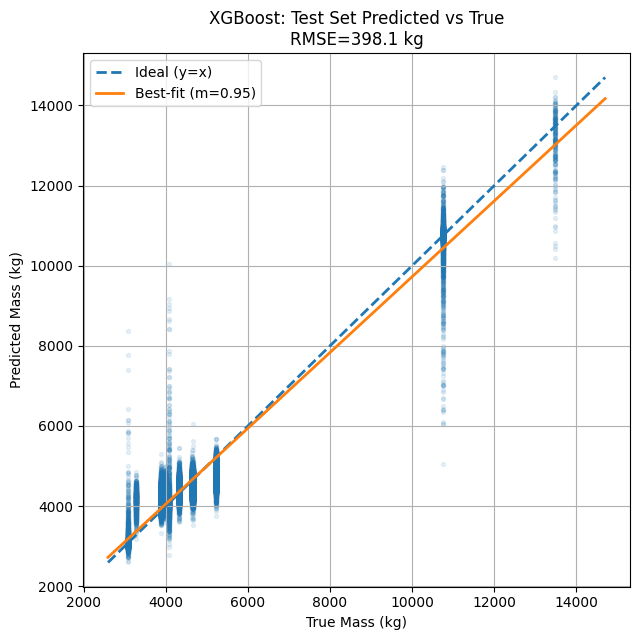

In [ ]:
# --- inside main code, AFTER running eval_and_plot or equivalent ---
# 1) Get test predictions
y_test_pred = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_true = np.asarray(y_test).ravel()
y_pred = np.asarray(y_test_pred).ravel()

# 2) Guard for NaNs/Infs
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true, y_pred = y_true[mask], y_pred[mask]

# 3) Compute RMSE and best-fit line
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
m, b = np.polyfit(y_true, y_pred, 1)

# 4) Plot Pred vs True
plt.figure(figsize=(6.5, 6.5))
plt.scatter(y_true, y_pred, s=8, alpha=0.1)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
xs = np.linspace(lims[0], lims[1], 200)
plt.plot(lims, lims, '--', lw=2, label='Ideal (y=x)')
plt.plot(xs, m*xs + b, lw=2, label=f'Best-fit (m={m:.2f})')
plt.xlabel('True Mass (kg)')
plt.ylabel('Predicted Mass (kg)')
plt.title(f'XGBoost: Test Set Predicted vs True\nRMSE={rmse_test:.1f} kg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
